# Generate average task gradients

1. with Glasser parcellation
    * fit grad aligned
2. (original) in fsaverage5 space, all & separate for both groups

3. Compare to Margulies2016 (get with neurompas)

### Add: Data prep & checks
check sub-file completenes on sciencecloud

In [2]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
import pandas as pd

bids_folder = '/mnt_03/ds-dnumrisk' 
target_dir = op.join(bids_folder,'derivatives','gradients')

subList = [f[4:6] for f in os.listdir(bids_folder) if f[0:4] == 'sub-' and len(f) == 6]

# group list
df_participants = pd.read_csv(op.join(bids_folder, 'add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
group_list = df_participants.loc[:,['subject ID','group']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')

source_folder = op.join(bids_folder,'derivatives','correlation_matrices')
target_folder = op.join(bids_folder,'derivatives','gradients')

specification = '' # align_spec = '_align-procrustes' 

# 1. Glasser parcellation (360x360)


In [3]:
space = 'fsaverage'
group = 'All'
n_components = 10

In [ ]:
# get average CM 

N_parcels = 360
av_cm = np.zeros((N_parcels, N_parcels))
N_subs = len(subList)

for sub in subList:
    cm_file = op.join(source_folder,f'sub-{sub}_glasserParcel-{space}.npy')
    try:
        cm = np.load(cm_file)
        av_cm += np.arctan(cm)
    except:
        print(f'sub-{sub} missing') 
        N_subs -= 1
    
av_cm = av_cm/N_subs
av_cm_transf = np.tan(av_cm) # sanity check: diagonal should be 1 !

np.save(op.join(source_folder,f'cm_av_glasserParcel_group-{group}.npy'), av_cm_transf)

In [18]:
from brainspace.gradient import GradientMaps

av_cm_transf = np.load(op.join(source_folder,f'cm_av_glasserParcel_group-{group}.npy'))

gm = GradientMaps(n_components=n_components) # defaults: approacch = 'dm', kernel = None
gm.fit(av_cm_transf)

#np.save(op.join(target_dir,f'gradients_av_glasserParcel_group-{group}.npy'), gm.gradients_) # save all together
#np.save(op.join(target_dir,f'lambdas_av_glasserParcel_group-{group}.npy'), gm.lambdas_) # save all together



/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/brainspace-0.1.4-py3.10.egg/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


GradientMaps()

In [17]:
len(labeling[(labeling != 1000) & (labeling != 2000)]) 

299876

In [ ]:
space = 'fsaverage5'

In [8]:
from utils import get_glasser_parcels
from brainspace.utils.parcellation import map_to_labels
 
gms = np.load(op.join(target_dir,f'gradients_av_glasserParcel_group-{group}.npy'),).T
#gms = gm.gradients_.T

mask, labeling = get_glasser_parcels(space = space )
print(mask.sum())

grad = [None] * n_components
for i, g in enumerate(gms): # unaligned
    grad[i] = map_to_labels(g, labeling, mask=mask, fill=np.nan)


299876


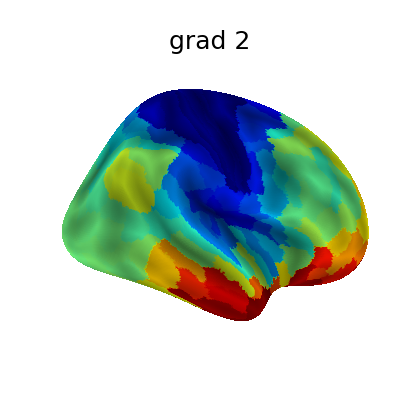

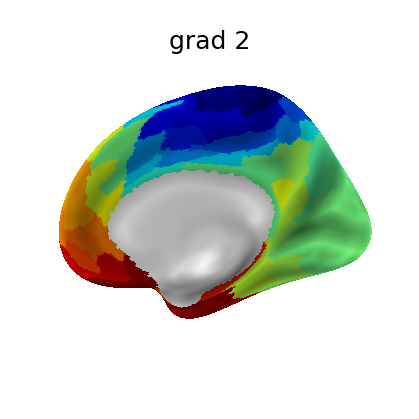

In [11]:
from  nilearn.datasets import fetch_surf_fsaverage
import nilearn.plotting as nplt
import matplotlib.pyplot as plt

fsaverage = fetch_surf_fsaverage(space) 
i = 1
gm = np.split(grad[i],2) # for i, hemi in enumerate(['L', 'R']): --> left first
gm_r = gm[1]# right
nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= gm_r, # infl_right # pial_right
            view= 'medial',cmap='jet', colorbar=False, title=f'grad {i+1}',
            bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7) 
plt.show()
nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= gm_r, # infl_right # pial_right
            view= 'lateral',cmap='jet', colorbar=False, title=f'grad {i+1}',
            bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.7) 
plt.show()

In [ ]:
# now fit grad aligned
from brainspace.gradient import GradientMaps

source_folder_cm = op.join(bids_folder,'derivatives','correlation_matrices')
source_folder_gm = op.join(bids_folder,'derivatives','gradients')
ref_grad = np.load(op.join(source_folder_gm,f'gradients_av_glasserParcel_group-{group}.npy'))

for sub in subList:
    cm_file = op.join(source_folder_cm,f'sub-{sub}_glasserParcel-{space}.npy')
    cm = np.load(cm_file) # 

    gm = GradientMaps(n_components=10,random_state=0, alignment='procrustes')
    gm.fit(cm, reference=ref_grad)

    target_folder_gm = op.join(bids_folder,'derivatives','gradients',f'sub-{sub}' )
    np.save(op.join(target_folder_gm,f'sub-{sub}_gradients_glasserParcel.npy'), gm.gradients_) # save all together
    np.save(op.join(target_folder_gm,f'sub-{sub}_g-aligned_glasserParcel.npy'), gm.aligned_)
    np.save(op.join(target_folder_gm,f'sub-{sub}_lambdas_glasserParcel.npy'), gm.lambdas_) # save all together



/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/brainspace-0.1.4-py3.10.egg/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')
/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/brainspace-0.1.4-py3.10.egg/brainspace/gradient/embedding.py:77: UserWarning: Graph is not fully connected.
  warnings.warn('Graph is not fully connected.')


# 2. Vertex resolution, fsav5 space

In [2]:
from utils import get_basic_mask

mask, labeling_noParcel = get_basic_mask()
N_vertices = len(np.where(mask==True)[0])


In [ ]:
# get average correlation matrix for all subs
group = 'All'

matrix_zeros = np.zeros((N_vertices, N_vertices))
av_cm = matrix_zeros.copy()

for sub in subList:
    try:
        correlation_matrix = np.load(op.join(source_folder,f'sub-{sub}_unfiltered{specification}.npy'))
        av_cm += np.arctan(correlation_matrix) # fisher-Z-transformed
        print(f'subject {sub} added')
    except:
        print(f'subject {sub} failed')

av_cm = av_cm/len(subList)
av_cm_transf = np.tan(av_cm) # sanity check: diagonal should be 1 !

np.save(op.join(source_folder,f'cm_av_ses1_fsav5_unfiltered.npy'), av_cm_transf)

In [ ]:
# groups seperate

group = 0
subList_fil = [x for x in subList if group_list.loc[int(x)]['group'] == group]

av_cm = np.zeros((N_vertices, N_vertices)) # matrix with zeros
for sub in subList_fil:
    try:
        correlation_matrix = np.load(op.join(source_folder,f'sub-{sub}_unfiltered{specification}.npy'))
        av_cm += np.arctan(correlation_matrix) # fisher-Z-transformed
    except:
        print(f'subject {sub} failed')
        
av_cm = av_cm/len(subList)
av_cm_transf = np.tan(av_cm) # sanity check: diagonal should be 1 !

np.save(op.join(source_folder,f'cm_av_group-{group}.npy'), av_cm_transf)

### now derive GMs from average CMs

In [11]:
from brainspace.gradient import GradientMaps
from brainspace.utils.parcellation import map_to_labels

sub = f'avGroup{group}'

n_components = 3 # reference gradient only has 3 components anyway... for better alignment one needs more components?! (according to Alam, 2022, L-R GM differences & cognition )

target_dir = op.join(bids_folder, 'derivatives', 'gradients', f'sub-{sub}')
if not op.exists(target_dir):
    os.makedirs(target_dir)

# load in reference gradient and apply same filter
g_ref = np.load(op.join(bids_folder,'derivatives', 'gradients','refGrad-av_task-risk_align-marg.npy')) # same labeling_noParcel as cm_unfiltered
#g_ref = g_ref[mask] # not needed here cause "unfiltered"

# now perform embedding on cleaned data + alignment
g_align_fil = GradientMaps(n_components=n_components,alignment='procrustes') # defaults: approacch = 'dm', kernel = None
g_align_fil.fit(av_cm_transf,reference=g_ref)
print(f'finished sub-{sub}: gradients generated')

gm = g_align_fil.gradients_.T # unaligned
grad = [None] * n_components
for i, g in enumerate(gm): # 
    grad[i] = map_to_labels(g, labeling_noParcel, mask=mask, fill=np.nan)
np.save(op.join(target_dir,f'sub-{sub}_gradients{specification}.npy'), grad) # save all together

gm = g_align_fil.aligned_.T # !!!! take .algined_ and not .gradients (which also exists, but those are not aligend)
grad = [None] * n_components
for i, g in enumerate(gm): # gm.gradients_.T
    grad[i] = map_to_labels(g, labeling_noParcel, mask=mask, fill=np.nan)

np.save(op.join(target_dir,f'sub-{sub}_gradients-aligned{specification}.npy'), grad) # save all together


/home/ubuntu/miniconda3/envs/numrefields/lib/python3.10/site-packages/brainspace-0.1.4-py3.10.egg/brainspace/gradient/embedding.py:70: UserWarning: Affinity is not symmetric. Making symmetric.
  warnings.warn('Affinity is not symmetric. Making symmetric.')


finished sub-avGroupAll: gradients generated


In [5]:
grad_folder = 'derivatives/gradients'
sub = 'All'
n_comp=10
fn_lambdas = op.join(bids_folder,grad_folder,f'sub-{sub}',f'sub-{sub}_lambdas_N-{n_comp}.npy')
lambdas = np.load(fn_lambdas)
lambdas


array([10.17917217,  9.54430138,  4.9798906 ,  3.93868058,  2.59086881,
        2.02154053,  1.72083095,  1.57858937,  1.37733587,  1.22280752])

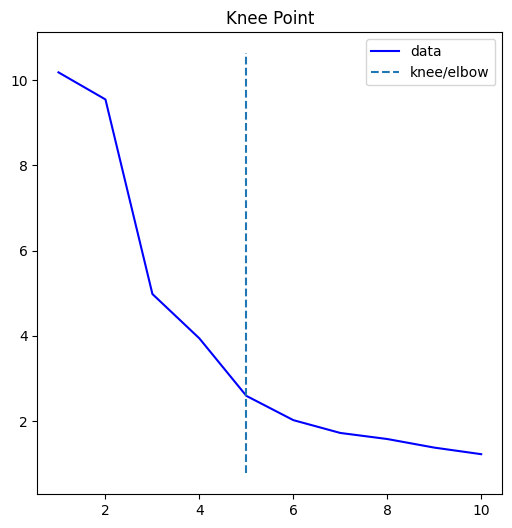

In [6]:
from kneed import KneeLocator #  knee point is the point of maximum curvature.

kneedle = KneeLocator(x=range(1,len(lambdas)+1), y= lambdas, S=1.0, curve="convex", direction="decreasing")
kneedle.plot_knee()
#kneedle.plot_knee_normalized()

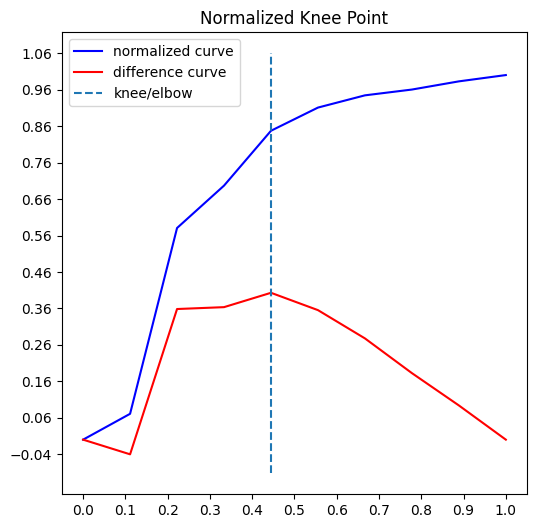

In [7]:
kneedle.plot_knee_normalized()

# 3. Compare to Margulies 2016

In [2]:
from neuromaps.datasets import available_annotations
grad_folder = 'derivatives/gradients'

sub='All'
n_comp = 10


In [3]:
from neuromaps.datasets import available_annotations
for annotation in available_annotations(source='margulies2016'):
     print(annotation)

('margulies2016', 'fcgradient01', 'fsLR', '32k')
('margulies2016', 'fcgradient02', 'fsLR', '32k')
('margulies2016', 'fcgradient03', 'fsLR', '32k')
('margulies2016', 'fcgradient04', 'fsLR', '32k')
('margulies2016', 'fcgradient05', 'fsLR', '32k')
('margulies2016', 'fcgradient06', 'fsLR', '32k')
('margulies2016', 'fcgradient07', 'fsLR', '32k')
('margulies2016', 'fcgradient08', 'fsLR', '32k')
('margulies2016', 'fcgradient09', 'fsLR', '32k')
('margulies2016', 'fcgradient10', 'fsLR', '32k')


In [4]:
from neuromaps.datasets import fetch_annotation

margulies2016 = fetch_annotation(source='margulies2016')


[References] Please cite the following papers if you are using this data:

  For {'source': 'margulies2016', 'desc': 'fcgradient01', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macroscale cortical organization. Proc Natl Acad Sci USA, 113(44):12574–12579, 2016.
  [secondary]:
    

  For {'source': 'margulies2016', 'desc': 'fcgradient02', 'space': 'fsLR', 'den': '32k'}:
  [primary]:
    Daniel S Margulies, Satrajit S Ghosh, Alexandros Goulas, Marcel Falkiewicz, Julia M Huntenburg, Georg Langs, Gleb Bezgin, Simon B Eickhoff, F Xavier Castellanos, Michael Petrides, and others. Situating the default-mode network along a principal gradient of macroscale cortical organization. Proc Natl Acad Sci USA, 113(44):12574–12579, 2016.
  [se

In [5]:
margulies2016['margulies2016','fcgradient02','fsLR','32k'][0]

'/home/ubuntu/neuromaps-data/annotations/margulies2016/fcgradient02/fsLR/source-margulies2016_desc-fcgradient02_space-fsLR_den-32k_hemi-L_feature.func.gii'

In [6]:
from neuromaps.stats import compare_images

my_grad1_L = '/mnt_03/ds-dnumrisk/derivatives/gradients/sub-All/sub-All_task-magjudge_space-fsLR_den-32k_hemi-L_grad5.surf.gii'
margulies_grad1_L= margulies2016['margulies2016','fcgradient04','fsLR','32k'][0]
corrcoef =  compare_images(my_grad1_L, margulies_grad1_L, metric='pearsonr') # , metric='pearsonr' # similarity,pvalue = if ( nulls= , return_nulls=True
print(corrcoef)


0.4515329897403717


In [12]:
pati = '/mnt_03/ds-dnumrisk/derivatives/gradients/sub-All/'

correlation_matrix = np.zeros((5, 5))

# Loop over gradients and calculate correlations
for i_my_grad in range(5):
    my_grad = op.join(pati, f'sub-All_task-magjudge_space-fsLR_den-32k_hemi-L_grad{i_my_grad+1}.surf.gii')
    for i_marg_grad in range(5):
        marg_grad = margulies2016['margulies2016',f'fcgradient0{i_marg_grad+1}','fsLR','32k'][0]
        corrcoef = compare_images(my_grad, marg_grad, metric='pearsonr')
        correlation_matrix[i_my_grad, i_marg_grad] = np.abs(corrcoef)

print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
[[0.47841421 0.66574013 0.18309674 0.32250455 0.16934131]
 [0.65424168 0.60037893 0.08437881 0.1606328  0.34285322]
 [0.19168867 0.07107814 0.3073431  0.12111856 0.29349336]
 [0.40327764 0.20633626 0.24351588 0.33390215 0.18945907]
 [0.21830265 0.10852097 0.58102947 0.45153299 0.04635227]]


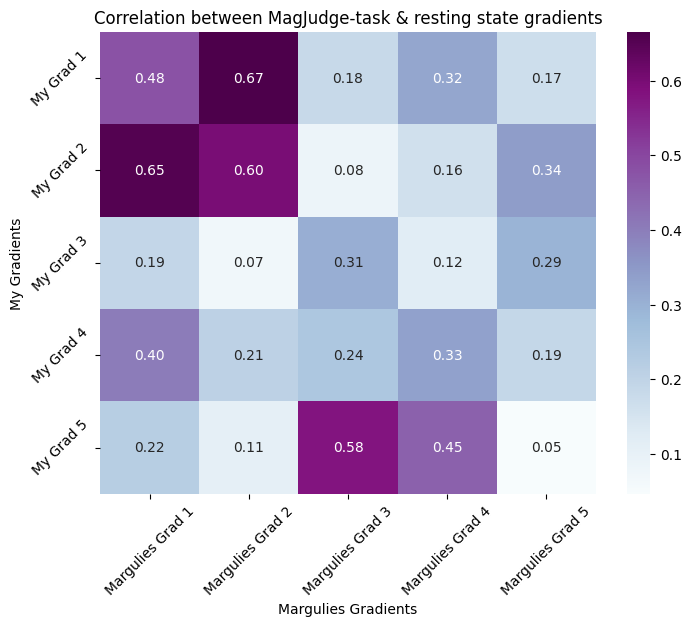

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="BuPu",
            xticklabels=[f'Margulies Grad {i+1}' for i in range(5)],
            yticklabels=[f'My Grad {i+1}' for i in range(5)])
plt.title("Correlation between MagJudge-task & resting state gradients")
plt.xlabel("Margulies Gradients")
plt.ylabel("My Gradients")

# Rotate the x-axis labels
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

# ADD: Data prep & checks

In [ ]:
# # check completens of files (over subs)
import glob
import re

key = 'desc-confounds_timeseries.tsv'

fns = glob.glob(f'{bids_folder}/derivatives/fmriprep/sub-*/ses-*/func/*{key}')
reg = re.compile(f'.*/sub-(?P<subject>[0-9]+)_ses-1_task-magjudge_run-(?P<run>[0-9]+)_{key}') # (?P<session>[0-9]+)
data = []

for fn in fns:
    try:
        data.append(reg.match(fn).groupdict())
        data[-1]['fn'] = fn
    except Exception as e:
        print(f'Problem with {fn}: {e}')

data = pd.DataFrame(data)
data['subject'] = [int(sub) for sub in data['subject']]
df = data.set_index(['subject',  'run']).unstack('run') # 'session',
df[df.isna().any(axis=1)]

In [ ]:
# File/Space conversions

from utils import saveGradToNPFile, npFileTofs5Gii
from utils_03 import npFileTofsLRGii

fn = op.join(bids_folder,grad_folder,f'sub-{sub}',f'sub-{sub}_gradients_N-{n_comp}.npy')
grad = np.load(fn)

saveGradToNPFile(grad,sub=sub, specification='_space-fsaverage5', bids_folder=bids_folder)
npFileTofs5Gii(sub=sub, space='fsaverage5', bids_folder=bids_folder)
npFileTofsLRGii(sub=sub, bids_folder=bids_folder)

In [ ]:
npFileTofsLRGii(sub=sub, bids_folder=bids_folder, gradient_Ns=[4,5])